In [15]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from PyAstronomy import pyaC
from scipy import stats
import cmocean
import random
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission_time = np.median(mission_dataset['time'][:])
mission_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 19
    summary: University of Washington - Applied Physics Lab team collected these data using microSWIFT wave buoys at the USACE Field Research Facility as part of the USCRP funded project DUNEX (During Nearshore Events Experiment). The file contains both directly measured and computed quantities from the drifting wave buoys. The collection and processing of these data is explained in the github repository at https://github.com/SASlabgroup/DUNEXMainExp along with examples of how these data can be used.
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim T

In [17]:
# Add in breaking location start based on gamma value for area and average shoreline location
# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
mission_hs = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)
print(mission_hs)

# Compute depth that waves should be breaking in 
mission_break_depth = mission_hs / gamma
print(mission_break_depth)

# Cross Shore Location for start of Breaking
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

mission_xs_gamma_location = np.interp(-mission_break_depth, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission_xs_gamma_location)

# Get shoreline location from waterlevel data
waterlevel_file = '../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
waterlevel_dataset = nc.Dataset(waterlevel_file)
waterlevel = waterlevel_dataset['waterLevel'][:]
waterlevel_time = waterlevel_dataset['time'][:]
mission_waterlevel = np.interp(mission_time, waterlevel_time, waterlevel)
print(mission_waterlevel)

mission_shoreline_location = np.interp(mission_waterlevel, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission_shoreline_location)

1.1538847635243603
3.2968136100696013
273.3005642795343
-0.3963334080643127
125.69255563551208


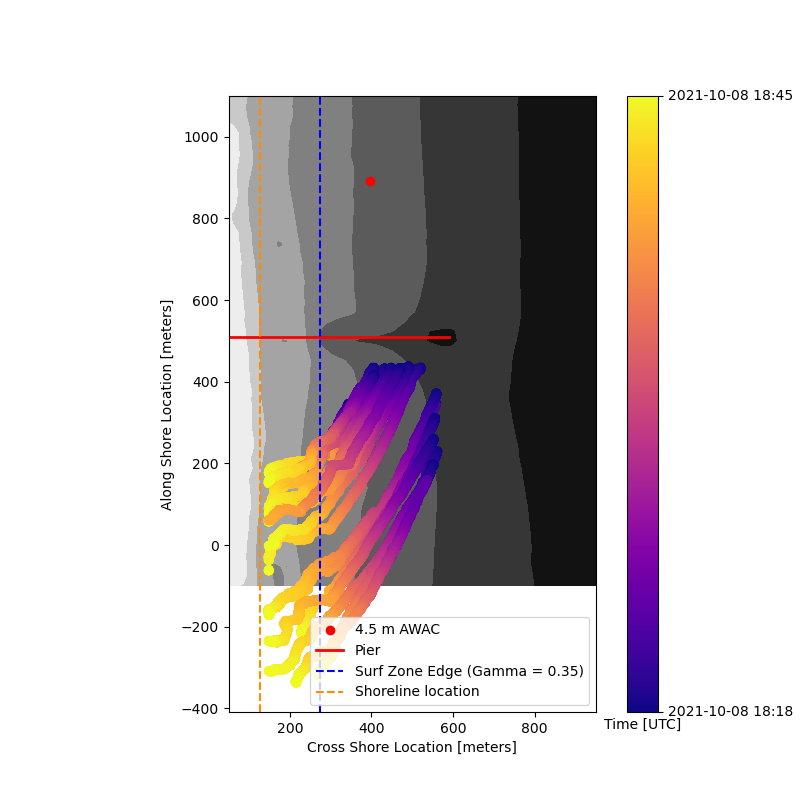

In [18]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
ax = mission_tools.plot_mission_tracks(mission_dataset, bathy_file)
ax.axvline(mission_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax.axvline(mission_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.legend(loc='lower right')

Text(0, 0.5, 'North-South Velocity [m/s]')

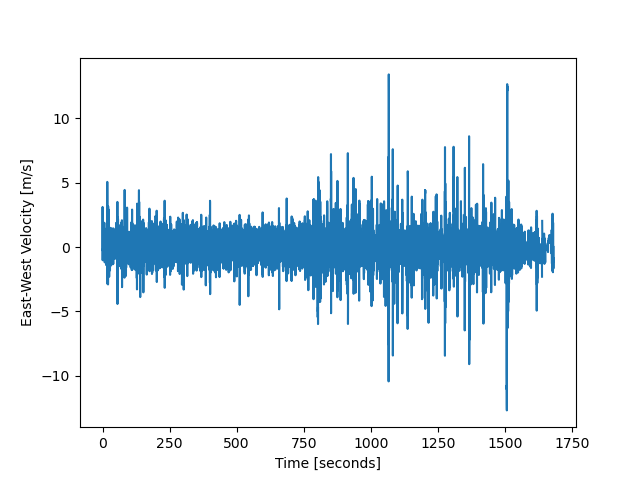

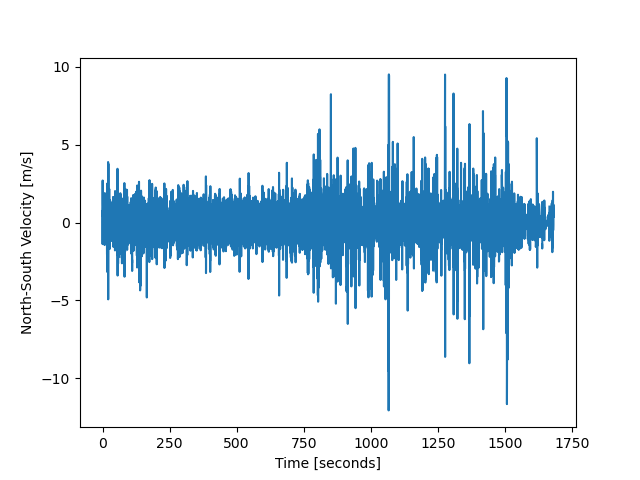

In [19]:
# Plot on cross shore and along shore velocities
microswift_num = 1
vel_ew = mission_dataset['velocity_ew'][microswift_num,:]
vel_ns = mission_dataset['velocity_ns'][microswift_num,:]
xFRF_test = mission_dataset['xFRF'][microswift_num,:]
yFRF_test = mission_dataset['yFRF'][microswift_num,:]
time_seconds = np.arange(vel_ew.size)/12

fig, ax = plt.subplots()
ax.plot(time_seconds, vel_ew)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('East-West Velocity [m/s]')

fig, ax = plt.subplots()
ax.plot(time_seconds, vel_ns)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('North-South Velocity [m/s]')

-94.46834689039004


Text(0, 0.5, 'Velocity Direction []')

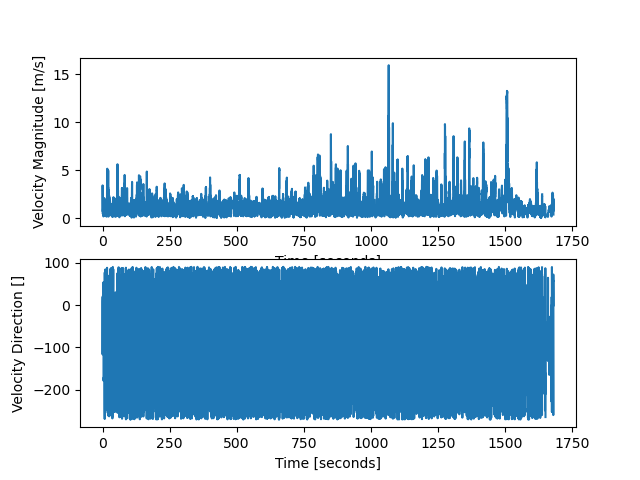

In [20]:
# Compute magnitude and direction of velocity
vel_mag = np.sqrt(vel_ns**2 + vel_ew**2)
vel_direction = (np.arctan2(vel_ns, vel_ew) * (180/np.pi)) - 90 # subtract 90 to be north 0 convention
vel_direction_mean = np.nanmean(vel_direction)
print(vel_direction_mean)

fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(time_seconds, vel_mag)
ax1.set_xlabel('Time [seconds]')
ax1.set_ylabel('Velocity Magnitude [m/s]')

ax2.plot(time_seconds, vel_direction)
ax2.set_xlabel('Time [seconds]')
ax2.set_ylabel('Velocity Direction []')

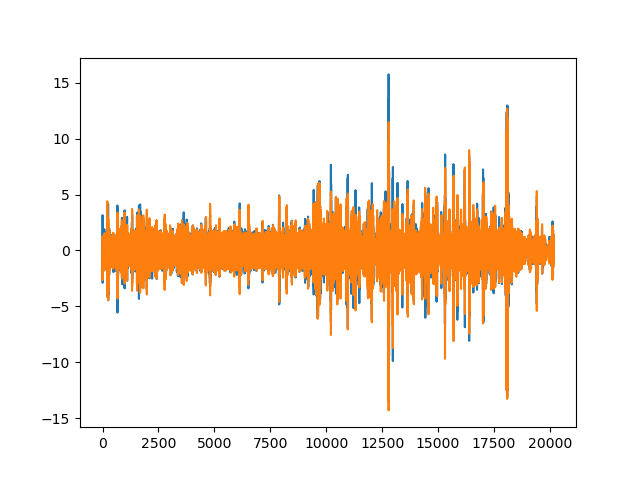

In [21]:
cross_shore_dir = 71.8 * (np.pi/180)
cross_shore_vel = vel_mag * np.cos(vel_direction + cross_shore_dir)
along_shore_vel = vel_mag * np.sin(vel_direction + cross_shore_dir)

fig, ax = plt.subplots()
ax.plot(cross_shore_vel)
ax.plot(along_shore_vel)

Text(0, 0.5, 'Along Shore Velocity [m/s]')

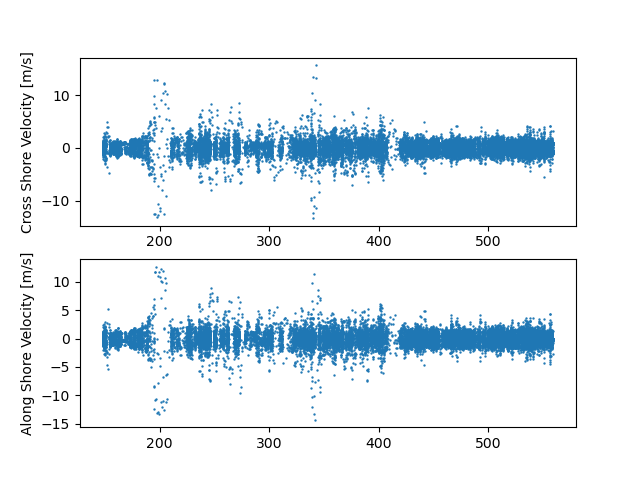

In [22]:
# Create histograms of velocity components
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(xFRF_test, cross_shore_vel, s=0.5)
ax1.set_ylabel('Cross Shore Velocity [m/s]')

ax2.scatter(xFRF_test, along_shore_vel, s=0.5)
ax2.set_ylabel('Along Shore Velocity [m/s]')

In [23]:
def smooth(array, window_size):
    num_windows = array.size//window_size
    return np.nanmean(np.reshape(array[:window_size*num_windows], (window_size, num_windows)), axis=0)

In [24]:
# Combine all measurements from mission
cross_shore_vel_tot = []
cross_shore_vel_tot_smooth = []
along_shore_vel_tot = []
xFRF_tot = []
xFRF_tot_smooth = []
yFRF_tot = []
vert_accel_tot = []

for microswift_num in range(mission_dataset['xFRF'].shape[0]):
    vel_ew = mission_dataset['velocity_ew'][microswift_num,:]
    vel_ns = mission_dataset['velocity_ns'][microswift_num,:]
    # vert_accel = mission_dataset['acceleration_z_body'][microswift_num,:]
    vert_accel = mission_dataset['acceleration_ud'][microswift_num,:]
    xFRF = mission_dataset['xFRF'][microswift_num,:]
    yFRF = mission_dataset['yFRF'][microswift_num,:]

    # Compute magnitude and direction of velocity
    vel_mag = np.sqrt(vel_ns**2 + vel_ew**2)
    vel_direction = (np.arctan2(vel_ns, vel_ew) * (180/np.pi)) - 90 # subtract 90 to be north 0 convention
    vel_direction_mean = np.nanmean(vel_direction)

    # Project velocity onto the cross shore and along shore directions
    cross_shore_dir = 71.8 * (np.pi/180)
    cross_shore_vel = vel_mag * np.cos(vel_direction + cross_shore_dir)
    along_shore_vel = vel_mag * np.sin(vel_direction + cross_shore_dir)

    # Append the cross and along shore velocities
    cross_shore_vel_tot.append(cross_shore_vel)
    along_shore_vel_tot.append(along_shore_vel)
    vert_accel_tot.append(vert_accel)
    xFRF_tot.append(xFRF)
    yFRF_tot.append(yFRF)

    # append Smoothed Values
    window_size = 12
    cross_shore_vel_tot_smooth.append(smooth(cross_shore_vel, window_size))
    xFRF_tot_smooth.append(smooth(xFRF, window_size))

# flatten the cross and along shore velocities
cross_shore_vel_tot = np.ma.concatenate(cross_shore_vel_tot)
along_shore_vel_tot = np.ma.concatenate(along_shore_vel_tot)
vert_accel_tot = np.ma.concatenate(vert_accel_tot)
xFRF_tot = np.ma.concatenate(xFRF_tot)
yFRF_tot = np.ma.concatenate(yFRF_tot)
cross_shore_vel_tot_smooth = np.ma.concatenate(cross_shore_vel_tot_smooth)
xFRF_tot_smooth = np.ma.concatenate(xFRF_tot_smooth)


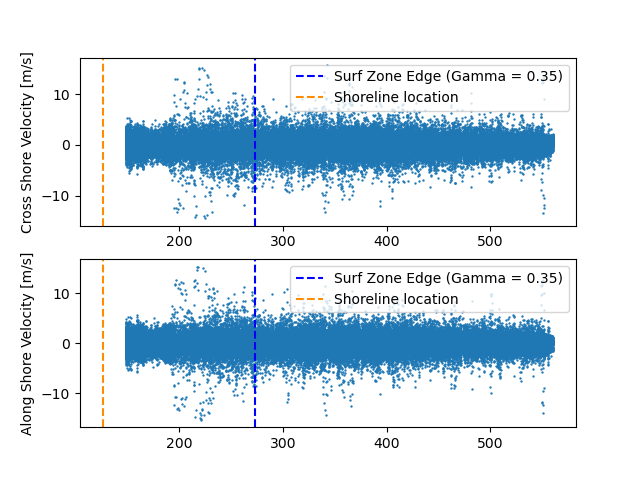

In [25]:
# Create histograms of velocity components
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.scatter(xFRF_tot, cross_shore_vel_tot, s=0.5)
ax1.set_ylabel('Cross Shore Velocity [m/s]')
ax1.axvline(mission_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax1.axvline(mission_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax1.legend()

ax2.scatter(xFRF_tot, along_shore_vel_tot, s=0.5)
ax2.set_ylabel('Along Shore Velocity [m/s]')
ax2.axvline(mission_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax2.axvline(mission_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax2.legend()

342737
1433


Text(0, 0.5, 'log(Probality Density) [-]')

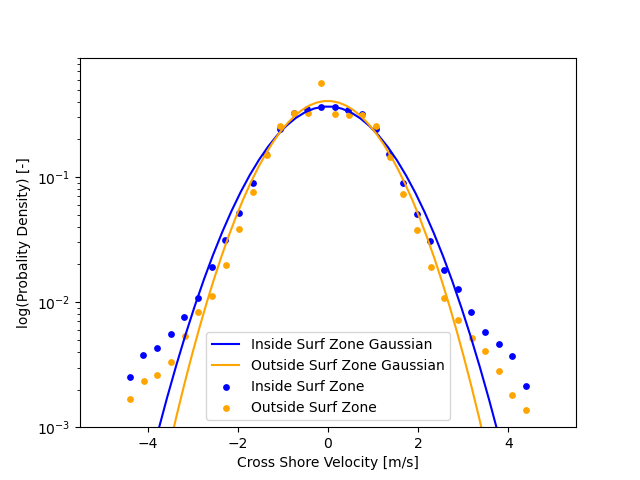

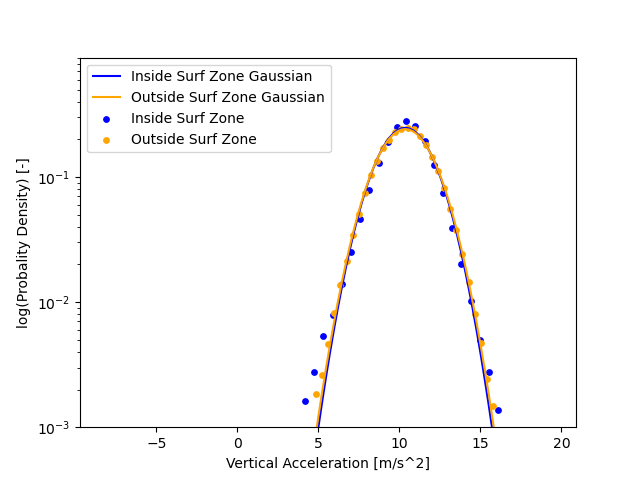

In [26]:
# Remove outliers
print(cross_shore_vel_tot.size)
print(np.where(np.abs(cross_shore_vel_tot)>4*np.std(cross_shore_vel_tot))[0].size)

outlier_inds = np.where(np.abs(cross_shore_vel_tot)>4*np.std(cross_shore_vel_tot))
cross_shore_vel_tot_no_outlier = np.delete(cross_shore_vel_tot, outlier_inds)
xFRF_tot_no_outlier = np.delete(xFRF_tot, outlier_inds)

# Histogram inside and outside of surfzone
cross_shore_vel_in_surf = cross_shore_vel_tot_no_outlier[xFRF_tot_no_outlier < (1 * mission_xs_gamma_location + 73)]
cross_shore_vel_out_surf = cross_shore_vel_tot_no_outlier[xFRF_tot_no_outlier > (1 * mission_xs_gamma_location + 73)]

vert_accel_in_surf = vert_accel_tot[xFRF_tot < (1 * mission_xs_gamma_location + 73)]
vert_accel_out_surf = vert_accel_tot[xFRF_tot > (1 * mission_xs_gamma_location + 73)]

bins = 30
cross_shore_vel_in_surf_dens, in_bin_edges = np.histogram(cross_shore_vel_in_surf,bins=bins, density=True)
cross_shore_vel_out_surf_dens, out_bin_edges = np.histogram(cross_shore_vel_out_surf,bins=bins, density=True)
in_bin_centers = (in_bin_edges[:-1] + in_bin_edges[1:])/2.
out_bin_centers = (out_bin_edges[:-1] + out_bin_edges[1:])/2.

vert_accel_in_surf_dens, vert_accel_in_bin_edges = np.histogram(vert_accel_in_surf.compressed(), bins=50, density=True)
vert_accel_out_surf_dens, vert_accel_out_bin_edges = np.histogram(vert_accel_out_surf.compressed(), bins=50, density=True)
vert_accel_in_bin_centers = (vert_accel_in_bin_edges[:-1] + vert_accel_in_bin_edges[1:])/2.
vert_accel_out_bin_centers = (vert_accel_out_bin_edges[:-1] + vert_accel_out_bin_edges[1:])/2.

# Compute gaussian inside and outside the surfzone with same mean and std 
xvals_insurf = np.linspace(-5, 5, 50)
xvals_outsurf = np.linspace(-4, 4, 50)
guassian_inside = stats.norm.pdf(xvals_insurf, np.mean(cross_shore_vel_in_surf), np.std(cross_shore_vel_in_surf))
guassian_outside = stats.norm.pdf(xvals_outsurf, np.mean(cross_shore_vel_out_surf), np.std(cross_shore_vel_out_surf))
vert_accel_guassian_inside = stats.norm.pdf(np.linspace(4, 16, 50), np.mean(vert_accel_in_surf), np.std(vert_accel_in_surf))
vert_accel_guassian_outside = stats.norm.pdf(np.linspace(4, 16, 50), np.mean(vert_accel_out_surf), np.std(vert_accel_out_surf))

fig, ax = plt.subplots()
ax.plot(xvals_insurf, guassian_inside, label='Inside Surf Zone Gaussian', color='b', linestyle='solid')
ax.plot(xvals_outsurf, guassian_outside, label='Outside Surf Zone Gaussian', color='orange', linestyle='solid')
ax.scatter(in_bin_centers, cross_shore_vel_in_surf_dens, label=f'Inside Surf Zone', s=15, color='b')
ax.scatter(out_bin_centers, cross_shore_vel_out_surf_dens, label=f'Outside Surf Zone', s=15, color='orange')
ax.set_ylim(10**-3, 0.9)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Cross Shore Velocity [m/s]')
ax.set_ylabel('log(Probality Density) [-]')

fig, ax = plt.subplots()
ax.plot(np.linspace(4, 16, 50), vert_accel_guassian_inside, label='Inside Surf Zone Gaussian', color='b', linestyle='solid')
ax.plot(np.linspace(4, 16, 50), vert_accel_guassian_outside, label='Outside Surf Zone Gaussian', color='orange', linestyle='solid')
ax.scatter(vert_accel_in_bin_centers, vert_accel_in_surf_dens, label=f'Inside Surf Zone', s=15, color='b')
ax.scatter(vert_accel_out_bin_centers, vert_accel_out_surf_dens, label=f'Outside Surf Zone', s=15, color='orange')
ax.set_ylim(10**-3, 0.9)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Vertical Acceleration [m/s^2]')
ax.set_ylabel('log(Probality Density) [-]')


(0.0001, 2)

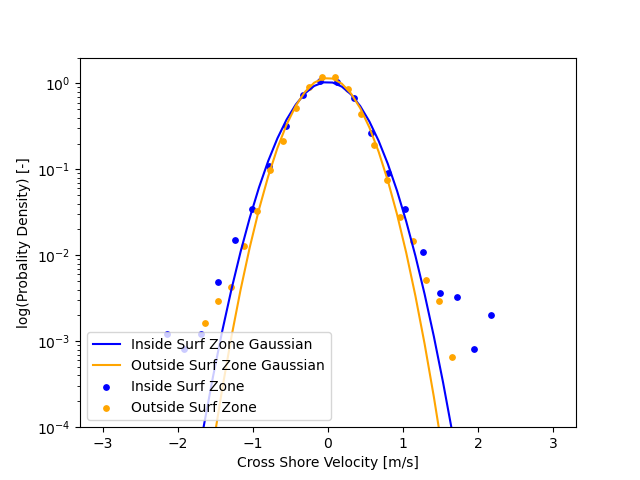

In [27]:
# Histogram inside and outside of surfzone
cross_shore_vel_in_surf_smooth = cross_shore_vel_tot_smooth[xFRF_tot_smooth < (1 * mission_xs_gamma_location + 73)]
cross_shore_vel_out_surf_smooth = cross_shore_vel_tot_smooth[xFRF_tot_smooth > (1 * mission_xs_gamma_location + 73)]

bins = 20
cross_shore_vel_in_surf_dens_smooth, in_bin_edges_smooth = np.histogram(cross_shore_vel_in_surf_smooth, bins=bins, density=True)
cross_shore_vel_out_surf_dens_smooth, out_bin_edges_smooth = np.histogram(cross_shore_vel_out_surf_smooth, bins=bins, density=True)
in_bin_centers_smooth = (in_bin_edges_smooth[:-1] + in_bin_edges_smooth[1:])/2.
out_bin_centers_smooth = (out_bin_edges_smooth[:-1] + out_bin_edges_smooth[1:])/2.

# Compute gaussian inside and outside the surfzone with same mean and std 
xvals_insurf_smooth = np.linspace(-3, 3, 50)
xvals_outsurf_smooth = np.linspace(-3, 3, 50)
guassian_inside_smooth = stats.norm.pdf(xvals_insurf_smooth, np.mean(cross_shore_vel_in_surf_smooth), np.std(cross_shore_vel_in_surf_smooth))
guassian_outside_smooth = stats.norm.pdf(xvals_outsurf_smooth, np.mean(cross_shore_vel_out_surf_smooth), np.std(cross_shore_vel_out_surf_smooth))

fig, ax = plt.subplots()
ax.plot(xvals_insurf_smooth, guassian_inside_smooth, label='Inside Surf Zone Gaussian', color='b', linestyle='solid')
ax.plot(xvals_outsurf_smooth, guassian_outside_smooth, label='Outside Surf Zone Gaussian', color='orange', linestyle='solid')
ax.scatter(in_bin_centers_smooth, cross_shore_vel_in_surf_dens_smooth, label=f'Inside Surf Zone', s=15, color='b')
ax.scatter(out_bin_centers_smooth, cross_shore_vel_out_surf_dens_smooth, label=f'Outside Surf Zone', s=15, color='orange')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Cross Shore Velocity [m/s]')
ax.set_ylabel('log(Probality Density) [-]')
ax.set_ylim(10**(-4), 2)

In [28]:
print(cross_shore_vel_in_surf_smooth.size)
print(cross_shore_vel_out_surf_smooth.size)

10776
17784
